# Boston Housing Prices Prediction Using Linear Regression
###### _Code and commentary by Alan Li_
___
### Linear Regression
___
Linear regression is one of the most useful and common models for making numerical predictions. Given a set of training data, a linear regression model aims to fit the data in such a way to as minimize the sum of the squared difference between the prediction and the actual value. This is known as the Least Squares Problem.

The result from this minimization of squared difference produces a model that should in theory be able to make an accurate prediction on a set of test data.

### The Dataset
___
The [Boston Houses dataset](http://lib.stat.cmu.edu/datasets/boston) contains 506 entries, with each entry consisting of 13 attributes of houses as well as the median price within the Boston area. In machine learning, the 13 attributes are called features of the data and the price is called the target.

The 13 features of this dataset are:
1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq. ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centers
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - percent lower status of the population

### Data Visualization
___
Whenever possible, it's always helpful to visualize and get a feel of the data before proceeding with the analysis. Since there are 13 features in this dataset, it makes sense to plot a graph to see the relationship between each feature and the price.

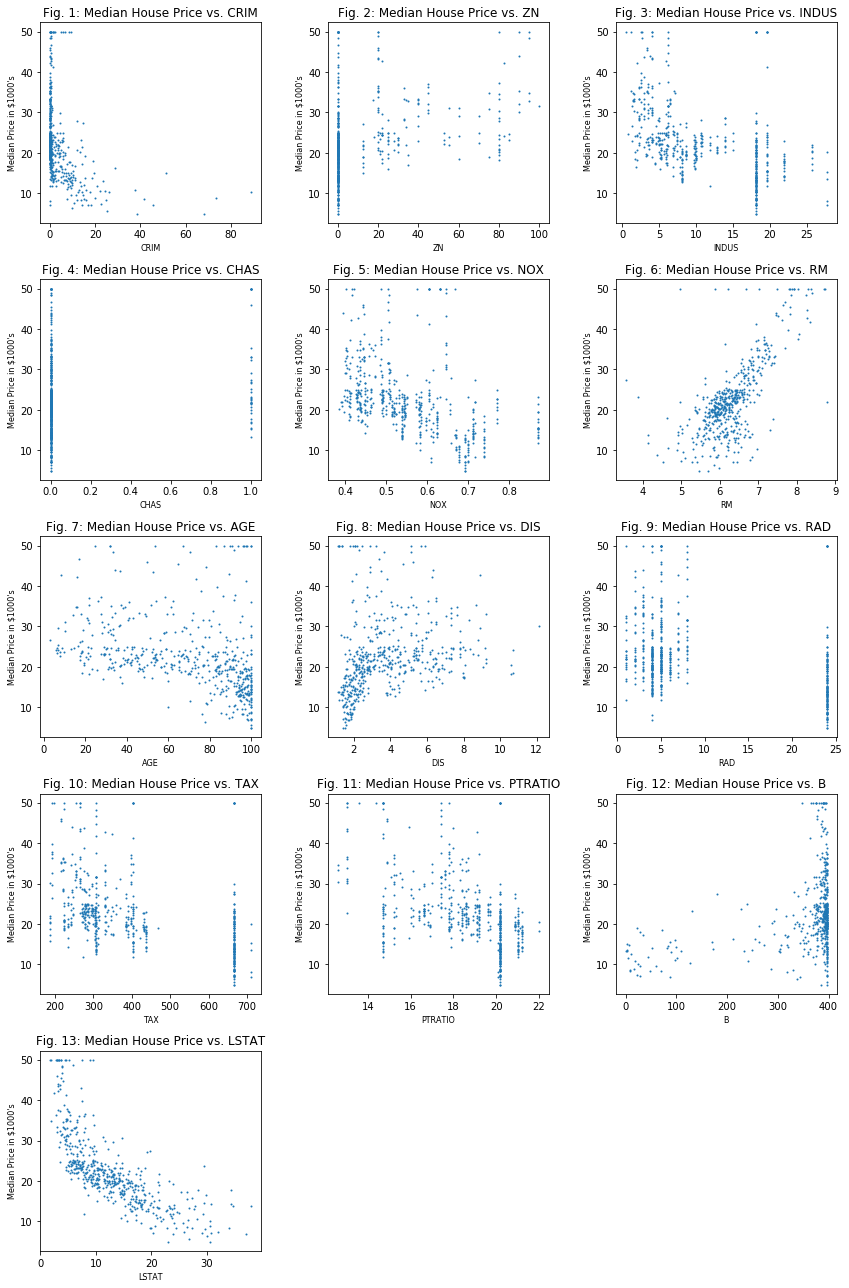

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

def load_data():
    boston = datasets.load_boston()
    X = boston.data
    y = boston.target
    features = boston.feature_names
    return X, y, features

def visualize(X, y, features):
    fig = plt.figure(figsize=(12, 18))
    feature_count = X.shape[1]

    for i in range(feature_count):
        ax = fig.add_subplot(5, 3, i + 1)
        ax.scatter(X[:, i], y, s=1)
        ax.set_xlabel(features[i], fontsize=8)
        ax.set_ylabel("Median Price in $1000's", fontsize=8)
        ax.set_title("Fig. {}: Median House Price vs. ".format(i + 1) + features[i], fontsize=12)
    plt.tight_layout()
    plt.show()
    
# load the data
X, y, features = load_data()

# plot the relationship between each feature and the price
visualize(X, y, features)

###### Comments on the data plots
Based observing the 13 data plots, it appears that some features are more strongly correlated to the price than others:
* Figure 6 shows a **positive** correlation between the number of rooms per house (RM) and the price, so the higher the number of rooms in the house, the higher the price. This makes intuitive sense because houses with more rooms are usually bigger, and therefore more expensive.
* Figure 13 shows a **negative** correlation between the percent of lower status of the population (LSTAT) and the price. This also makes sense as areas with high percentage of lower status of the population will tend to have smaller, less expensive houses.

Other features, such as the Charles River dummy variable in Figure 4, does not seem to provide much information on the price.

### Data Division
___
With the initial data visualization done, it's now time to prepare the data for training. To do so, we first divide the entire dataset into two groups:
1. the training set
2. the test set

The division is usually around 80/20 split between the training and test set, respectively.

The more training data that the model has access to, the more accurate it tends to be. However, the goal of machine learning is to make accurate predictions on **new, unseen data**, not on data it has already seen. Therefore, a small portion of the dataset is reserved as the test set and is not shown to the model during the training phase.

After the model has completed training, it is asked to make predictions on the test set. By comparing the predicted values on the test set with the actual values, you can get an idea of how well your model will perform on unseen data.

In [2]:
# randomly split data into 80% (405/506) train and 20% (101/506) test
# combine X and y first, shuffle, divide 80/20, then separate back into X and y for train and test set
y_column_vector = y.reshape(y.shape[0], -1)
boston_full_dataset = np.concatenate((X, y_column_vector), axis=1)
shuffled_indexes = np.arange(boston_full_dataset.shape[0])
np.random.shuffle(shuffled_indexes)
train_data, test_data = boston_full_dataset[shuffled_indexes[:405],:], boston_full_dataset[shuffled_indexes[405:],:]
train_X = train_data[:, :13]
train_y = train_data[:, 13:]
test_X = test_data[:, :13]
test_y = test_data[:, 13:]

### Data Normalization
___
Normally (no pun intended), it's a good idea to normalize the input features prior to training the model. In this example, normalizing the data is done by subtracting the value of each feature by the feature mean, then dividing the result by the difference between the max and min values in the feature.

In [3]:
def normalize_mean(X):
    for i in range(0, X.shape[1]):
        X_mean = np.mean(X[:, i])
        X_max = np.max(X[:, i])
        X_min = np.min(X[:, i])
        X[:, i] = (X[:, i] - X_mean) / (X_max - X_min)
    return X

train_X_norm = normalize_mean(train_X)
test_X_norm = normalize_mean(test_X)

### Linear Regression Model
___
With the data split 80/20 between the training and test set, we are ready to begin training the model. Actually, in simple linear regression problems like this, the optimal model can be solved analytically with a linear algebra equation.

The goal of the model is to reduce the sum of the squared error between the predicted price and the actual price on the training set. This goal is expressed as a function, known as the **objective function**:
$$w^{*} = \textrm{arg min} \sum_{i=1}^{N} (y^{(i)} - \hat{y}^{(i)})^{2}$$
$$w^{*} = \textrm{arg min} \sum_{i=1}^{N} (y^{(i)} - w^{T}x^{(i)})^{2}$$
$w^{*}$ - the optimal parameters of the linear regression model  
$y^{(i)}$ - the actual price (given in the dataset)  
$\hat{y}^{(i)}$ - the predicted price  
$w^{T}$ - the transpose of the parameters of some (non-optimal) model  
$x^{(i)}$ - the values of the features (given the dataset)

While it's possible to iteratively train a non-optimal model to achieve the optimal model using a method called **[gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)**, the analytical solution to the optimal model, $w^{*}$, only requires knowledge of $x^{(i)}$'s and $y^{(i)}$'s.

Concretly, if we represent all the $x^{(i)}$'s and $y^{(i)}$'s in matrix form:
* $\textbf{X}$ - matrix where rows represents the entry and columns represent the feature, with the **first column being all 1's** (this is known as the bias)
* $\textbf{y}$ - column vector where the each row represents the price

Then the solution to the optimal parameters of the linear regression model is simply:
$$w^{*}=(\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}\textbf{y}$$


In [4]:
def add_ones(X):
    ones = np.ones(X.shape[0]).reshape(X.shape[0], -1)
    X = np.concatenate((ones, X), axis=1)
    return X

def fit_regression(X, y):
    # numpy.linalg.solve(A, b) solves the equation A*x=b for x, i.e. x = A^{-1} * b
    W = np.linalg.solve(np.matmul(X.T, X), np.matmul(X.T, y))
    return W

# add column of 1's, or the bias, to the input matrix
train_X_norm = add_ones(train_X_norm)
test_X_norm = add_ones(test_X_norm)

# fit regression model using the analytical formula
w_norm = fit_regression(train_X_norm, train_y)
print("The optimal weight vector, w*, is: {}".format(w_norm.T))

# check how well the model fits the training data
train_prediction = np.matmul(train_X_norm, w_norm)

The optimal weight vector, w*, is: [[22.46 -10.25 3.21 0.34 2.88 -7.09 21.10 -0.65 -14.76 7.58 -7.04 -9.13
  3.73 -18.88]]


###### Comment on the optimal weight vector, $w^{*}$

The vector has 14 values when there are only 13 features. This is because the first value (22.46) in the vector is the weight for the bias (the column of 1's added earlier) in the input. The second value in $w^{*}$ correponds to the weight for the first feature, CRIM. The third value correponds to the second feature, ZN, and so on.

Notice that excluding the bias, the most positive value for $w^{*}$ is 21.10, corresponding to the feature RM and the most negative value for $w^{*}$ is -18.88, corresponding to the feature LSTAT. Since the predicted price produced by the model is a sum of elementwise product of the weight and its corresponding feature, the feature RM will contribute **significantly and positively** to the predicted price while the feature LSTAT will contribute **significantly and negatively** to the predicted price. This aligns with the intuition provided by the data visualization plots earlier.

### Making Predictions
___
Now that we have the optimal model based on the training data, we can use it to make price predictions on the test data

In [5]:
# use the weights of the model to predict the price on the test set
test_prediction = np.matmul(test_X_norm, w_norm)

### Quantify Model Performance
___
We need a quantitative way to measure how well the model performs. The mean squared error (MSE) is a widely used measure of model performance since it is the same metric used in the objective function. It measures the average of the squared difference between the predicted and actual price. Since the difference is squared, an outlier will highly contribute to the sum.
$$\textrm{MSE} = \frac{1}{N}\sum_{i=1}^{N} (y^{(i)}_{predicted} - y^{(i)}_{actual})^{2}$$

Another measure can be the median absolute error (MAE), which is the median out of all absolute values of the error.
$$\textrm{MAE} = \textrm{median}(|y^{(i)}_{predicted} - y^{(i)}_{actual}|)$$


In [6]:
def calculate_mean_squared_error(y1, y2):
    return (1 / y1.shape[0]) * np.sum(np.square(np.subtract(y1, y2)))

def calculate_median_absolute_error(y1, y2):
    return np.median(np.absolute(np.subtract(y1, y2)))

# compute MSE and MAE on training data
MSE_train = calculate_mean_squared_error(train_prediction, train_y)
MAE_train = calculate_median_absolute_error(train_prediction, train_y)

# compute MSE and MAE on test data
MSE_test = calculate_mean_squared_error(test_prediction, test_y)
MAE_test = calculate_median_absolute_error(test_prediction, test_y)

print("MSE and MAE on the train set are: {} and {}, in $1000's, respectively".format(np.around(MSE_train, decimals=2), np.around(MAE_train, decimals=2)))
print("MSE and MAE on the test set are: {} and {}, in $1000's, respectively".format(np.around(MSE_test, decimals=2), np.around(MAE_test, decimals=2)))

MSE and MAE on the train set are: 21.18 and 2.38, in $1000's, respectively
MSE and MAE on the test set are: 30.32 and 2.7, in $1000's, respectively


###### Comment on the errors

* The MSE and MAE are lower in the training set because the model is trained based on the training set, which means that by definition, it's tuned to perform as best as possible on the training set. In machine learning, the two primary goals are to reduce the training error as much as possible while making sure that the training error and the test error does not deviate too much. This can be achieved via a technique called **<a href="https://en.wikipedia.org/wiki/Regularization_(mathematics)">regularization</a>**
* The MSE is so much larger than the MAE because MSE measures the **squared** of the error, so any outliers will contribute significantly to the total error
* A simple interpretation on the MAE of 2.7 on the test set is that out of all predictions, the median absolute error made is approximately $2,700 from the actual price.

### The End